***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Intro: Merkmasstrukturbasierte Grammatik (*feature-based* CFG)

In [1]:
import nltk
from nltk import Tree
from nltk.featstruct import FeatStruct

In [2]:
def test_fcfg_grammar(gramstring, sent, draw=0, tracing=0):
    grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
    parser = nltk.parse.FeatureChartParser(grammar,trace=tracing)
    analyzed = False
    for tree in parser.parse(sent):
        print(tree)
        if draw: display(tree)
        analyzed = True
    if not analyzed:
        print("Keine Analyse möglich")    

def test_cfg_grammar(grammar, sent, tracing=0):
    parser = nltk.ChartParser(grammar,trace=tracing)
    analyzed = False
    for tree in parser.parse(sent):
        tree.pretty_print(unicodelines=True)
        analyzed = True
    if not analyzed:
        print("Keine Analyse möglich")            
        

---
## 1. CFG (Überproduktion aufgrund Nichtbeachtung Morphologie und Subkategorisierung)

In [3]:
grammar = nltk.CFG.fromstring("""
S -> NP VP

NP -> Det N

VP -> V

VP -> V NP

Det -> 'der' | 'dem' | 'den' | 'die'

N -> 'Hund' | 'Hunde' |'Hunden' |'Katze' |'Katzen'

V -> 'sieht' | 'sehen' | 'hilft' | 'helfen' | 'läuft' | 'laufen'

""")


In [4]:
sent = 'der Hund sieht die Katze'.split()
test_cfg_grammar(grammar, sent)

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
der     Hund sieht die     Katze



In [5]:
#SUBKATEGORISIERUNG:
sent = 'der Hund sieht'.split()
test_cfg_grammar(grammar, sent)

         S        
     ┌───┴─────┐   
     NP        VP 
 ┌───┴───┐     │   
Det      N     V  
 │       │     │   
der     Hund sieht



In [6]:
#SUBJEKT-KONGRUENZ:
sent = 'der Hund sehen die Katze'.split()
test_cfg_grammar(grammar, sent)

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
der     Hund sehen die     Katze



In [7]:
#KASUS-REKTION:
sent = 'dem Hund sieht der Katze'.split()
test_cfg_grammar(grammar, sent)

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
dem     Hund sieht der     Katze



---
## 2. FCFG (mit Constraints zur Verhinderung der Überproduktion)

### https://www.nltk.org/book/ch09.html#case-and-gender-in-german

#### vgl. https://www.nltk.org/book/ch09.html#subcategorization

In [8]:
gramstring = r"""
% start S

S -> NP[CASE=nom, AGR=?a] VP[AGR=?a]

NP[CASE=?c, AGR=?n] -> Det[CASE=?c, AGR=?n] N[CASE=?c, AGR=?n]

VP[AGR=?v] -> V[AGR=?v, SUBCAT=0]
VP[AGR=?v] -> V[OBJCASE=?c, AGR=?v, SUBCAT=1] NP[CASE=?c]

## Übersicht Constraints (als Pfadgleichungen):
    ## Subjekt-Kasusrektion = Zeile 4: <NP CASE> = nom 
    ## Objekt-Kasusrektion = Zeile 9: <V OBJCASE> = <NP CASE>
    ## Subjektkongruenz = Zeile 4: <NP AGR> = <VP AGR>
    ## Subkategorisierung = Zeilen 8,9: <V SUBCAT>= 0/1

    ## nominale Kongruenz = Zeile 6: <Det AGR> = <N AGR>

# masc
Det[CASE=nom, AGR=[GND=masc,PER=3,NUM=sg]] -> 'der' 
Det[CASE=dat, AGR=[GND=masc,PER=3,NUM=sg]] -> 'dem'
Det[CASE=acc, AGR=[GND=masc,PER=3,NUM=sg]] -> 'den'

# fem
Det[CASE=nom, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
Det[CASE=dat, AGR=[GND=fem,PER=3,NUM=sg]] -> 'der'
Det[CASE=acc, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 


# Plural determiners
Det[CASE=nom, AGR=[PER=3,NUM=pl]] -> 'die' 
Det[CASE=dat, AGR=[PER=3,NUM=pl]] -> 'den' 
Det[CASE=acc, AGR=[PER=3,NUM=pl]] -> 'die' 

# Nouns
N[AGR=[GND=masc,PER=3,NUM=sg]] -> 'Hund'
N[CASE=nom, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[CASE=dat, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunden'
N[CASE=acc, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'

N[AGR=[GND=fem,PER=3,NUM=sg]] -> 'Katze'
N[AGR=[GND=fem,PER=3,NUM=pl]] -> 'Katzen'

# Verbs
V[OBJCASE=acc, AGR=[NUM=sg,PER=3], SUBCAT=1] -> 'sieht'
V[OBJCASE=acc, AGR=[NUM=pl,PER=3], SUBCAT=1] -> 'sehen'
V[OBJCASE=dat, AGR=[NUM=sg,PER=3], SUBCAT=1] -> 'hilft'
V[OBJCASE=dat, AGR=[NUM=pl,PER=3], SUBCAT=1] -> 'helfen'
V[AGR=[NUM=sg,PER=3], SUBCAT=0] -> 'läuft'
V[AGR=[NUM=pl,PER=3], SUBCAT=0] -> 'laufen' 
"""

(S[]
  (NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom']
    (Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] der)
    (N[AGR=[GND='masc', NUM='sg', PER=3]] Hund))
  (VP[AGR=[NUM='sg', PER=3]]
    (V[AGR=[NUM='sg', PER=3], OBJCASE='acc', SUBCAT=1] sieht)
    (NP[AGR=[GND='fem', NUM='sg', PER=3], CASE='acc']
      (Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='acc'] die)
      (N[AGR=[GND='fem', NUM='sg', PER=3]] Katze))))


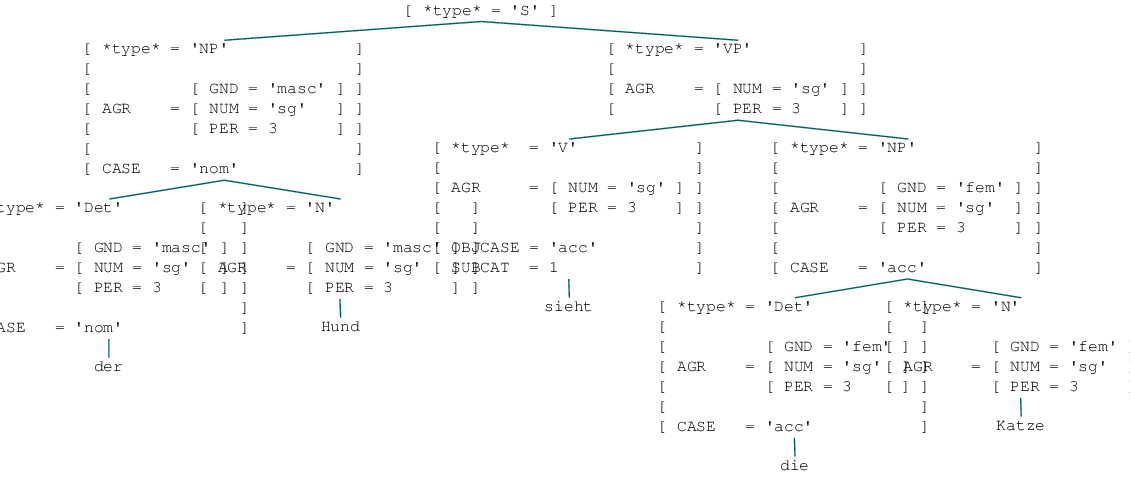

In [9]:
sent = 'der Hund sieht die Katze'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [10]:
#SUBKATEGORISIERUNG:
sent = 'der Hund sieht'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


In [11]:
#SUBJEKT-KONGRUENZ:
sent = 'der Hund sehen die Katze'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


In [12]:
#KASUS-REKTION:
sent = 'dem Hund sieht der Katze'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


---
### mit Tracing:

In [13]:
#Positivbeispiel:
sent = 'der Hund läuft'.split()
test_fcfg_grammar(gramstring, sent, draw=0,tracing=2)

|.der .Hund.läuf.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'der'
|.    [----]    .| [1:2] 'Hund'
|.    .    [----]| [2:3] 'läuft'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> 'der' *
|[----]    .    .| [0:1] Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='dat'] -> 'der' *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'dat', ?n: [GND='fem', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'nom', ?n: [GND='masc', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] N[AGR=[GND='masc', NUM='sg', PER=3]] -> 'Hund' *
Feature Single Edge Fundamental Rule:
|[---------]    .| [0:2] NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] N[AGR=[GND='masc', NUM

In [14]:
#SUBJEKT-KONGRUENZ:
sent = 'der Hund laufen'.split()
test_fcfg_grammar(gramstring, sent, draw=0,tracing=2)

|.der .Hund.lauf.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'der'
|.    [----]    .| [1:2] 'Hund'
|.    .    [----]| [2:3] 'laufen'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> 'der' *
|[----]    .    .| [0:1] Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='dat'] -> 'der' *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'dat', ?n: [GND='fem', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'nom', ?n: [GND='masc', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] N[AGR=[GND='masc', NUM='sg', PER=3]] -> 'Hund' *
Feature Single Edge Fundamental Rule:
|[---------]    .| [0:2] NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] N[AGR=[GND='masc', NU